# Imports

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.io as sio
from math import floor

# Load the data

In [2]:
file = 'hwkdataNEW.mat'
data_dict = sio.loadmat(file)
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y'])


Extract the parts we want and examine them

In [3]:
x = data_dict['x']
y = data_dict['y']

In [4]:
x.shape

(247, 14)

In [5]:
y.shape

(247, 1)

We want to put this all into the `pandas` data format

In [6]:
column_names = ['Age', 'Weight', 'Height', 'Adiposity Index', 
                'Neck Circumference', 'Chest Circumference', 
                'Abdomen Circumference', 'Hip Circumference',
                'Thigh Circumference', 'Knee Circumference',
                'Ankle Circumference', 'Extended Bicep Circumference',
                'Forearm Circumference', 'Wrist Circumference',
                'Body Fat Percentage']

In [7]:
data = pd.DataFrame(x, columns=column_names[:-1]) # Last column contains y

In [8]:
data[column_names[-1]] = y

In [9]:
data.head()

,Age,Weight,Height,Adiposity Index,Neck Circumference,Chest Circumference,Abdomen Circumference,Hip Circumference,Thigh Circumference,Knee Circumference,Ankle Circumference,Extended Bicep Circumference,Forearm Circumference,Wrist Circumference,Body Fat Percentage
0,23.0,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6
1,22.0,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9
2,22.0,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6
3,26.0,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9
4,24.0,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8


Data is now a pandas DataFrame that contains the information we need

# Sort into Train, Test, and Validation

Since the rows of data should be indpendent and uncorrelated, I have chosen to simply shuffle them then tag them as belonging to one of the named data sets (`train`, `test`, or `validation`).

In [10]:
train_frac = 0.5
test_frac = 0.25
val_frac = 0.25

train_len = floor(len(data) * train_frac)
test_len = floor(len(data) * test_frac)
val_len = floor(len(data) * val_frac)
rows_used = train_len + test_len + val_len
# Make sure all rows being used by adding unused
# rows into the training set
while rows_used < len(data):
    train_len += 1
    rows_used = train_len + test_len + val_len
print(f'Rows in original dataset: {len(data)}')
print(f'Rows in training dataset: {train_len}')
print(f'Rows in testing dataset: {test_len}')
print(f'Rows in validation dataset: {val_len}')
print(f'Rows used: {train_len + test_len + val_len}')

Rows in original dataset: 247
Rows in training dataset: 125
Rows in testing dataset: 61
Rows in validation dataset: 61
Rows used: 247


In [11]:
# Shuffle and reindex the dataset
data = data.sample(frac=1).reset_index(drop=True)
# Split the data into three datasets
dataset_labels = np.zeros(len(data)).astype('str')
dataset_labels[:train_len] = 'train'
dataset_labels[train_len:train_len + test_len] = 'test'
dataset_labels[-val_len:] = 'val'
data['sample'] = dataset_labels

## TO DO: Make sure max and min for each column is in training set

# Regression

Explanation of regression

In [17]:
train = data[data['sample']=='train']

In [36]:
def regress(x, y):
    """Returns coefficient of regression"""
    # One-pad x
    o = np.ones_like(x[:,0]).reshape((-1, 1))
    
    x = np.hstack([x, o])
    
    # Perform regression
    coefficients = la.inv(x.T @ x) @ x.T @ y
    
    return coefficients

In [47]:
def performance(x_test, y_test, coefficients):
    """Root mean squared error"""
    # One-pad x
    o = np.ones_like(x_test[:,0]).reshape((-1, 1))
    x_test = np.hstack([x_test, o])
    
    # Make predictions
    y_pred = x_test @ coefficients

    # Calculate RMSE
    return np.sqrt(np.sum((y_test - y_pred) ** 2) / y_test.shape[0])

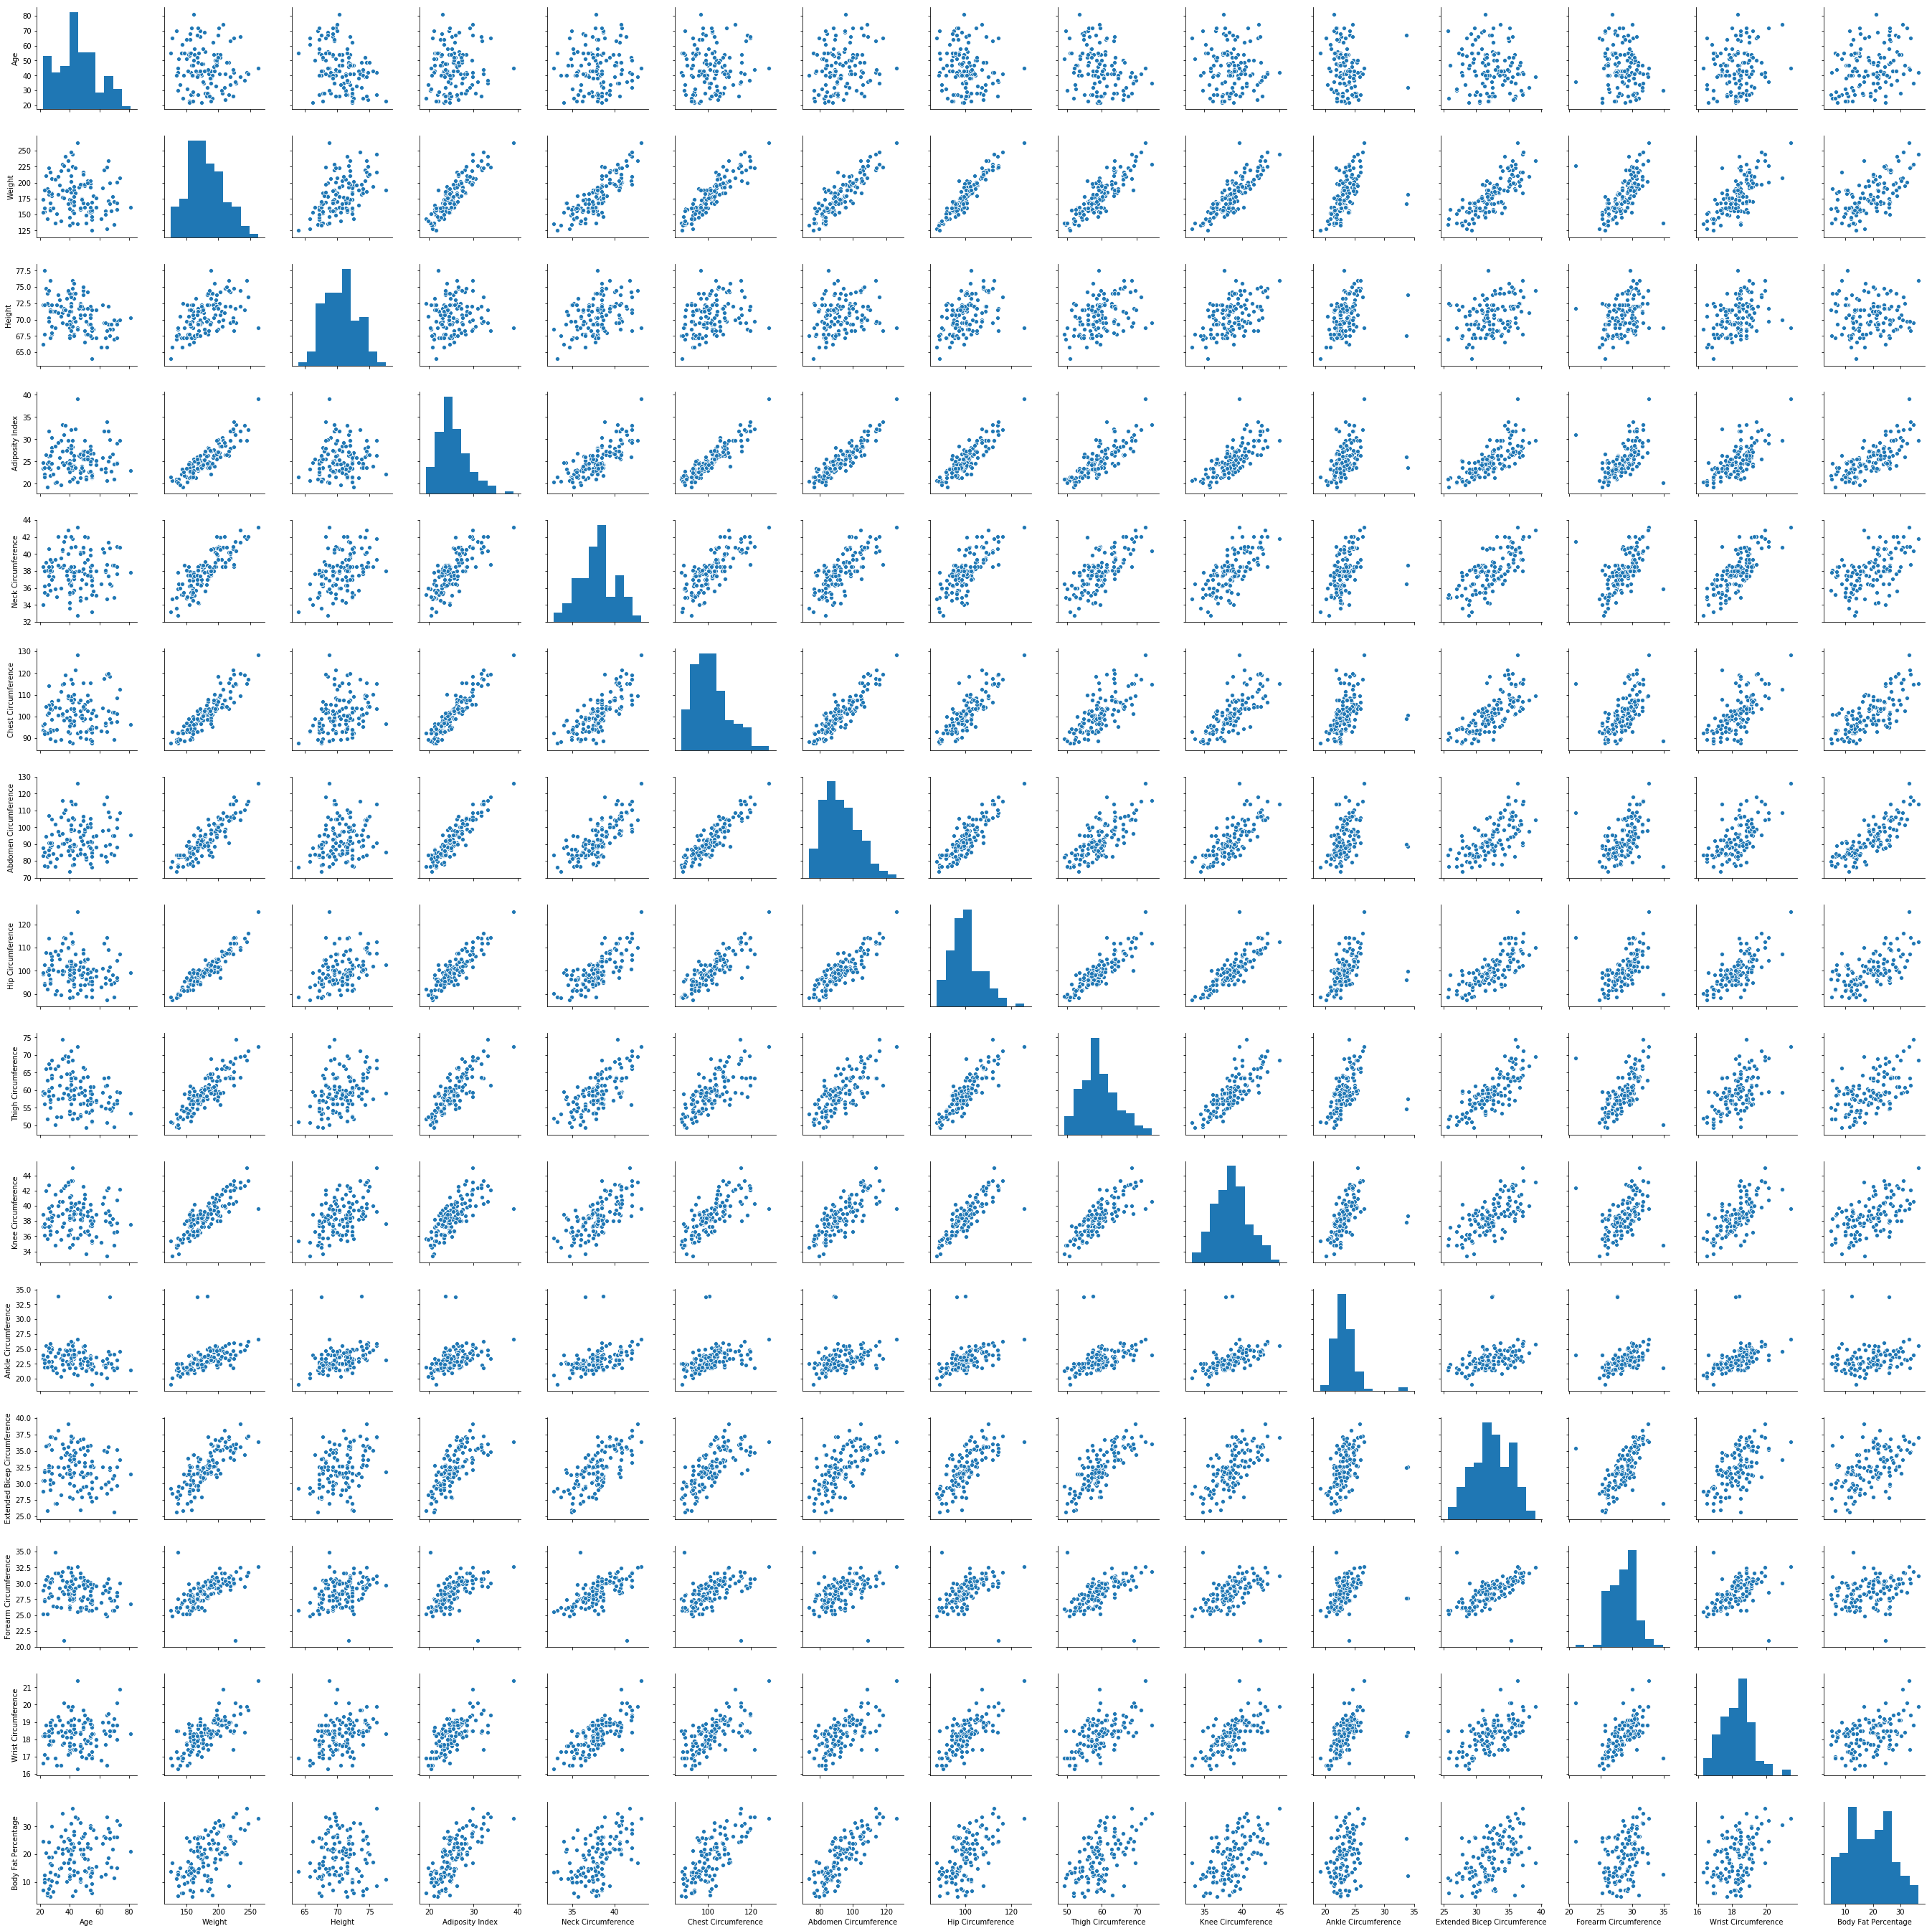

In [18]:
sns.pairplot(train)

Wow, that's a little unweildy. Let's try just the correlation matrix

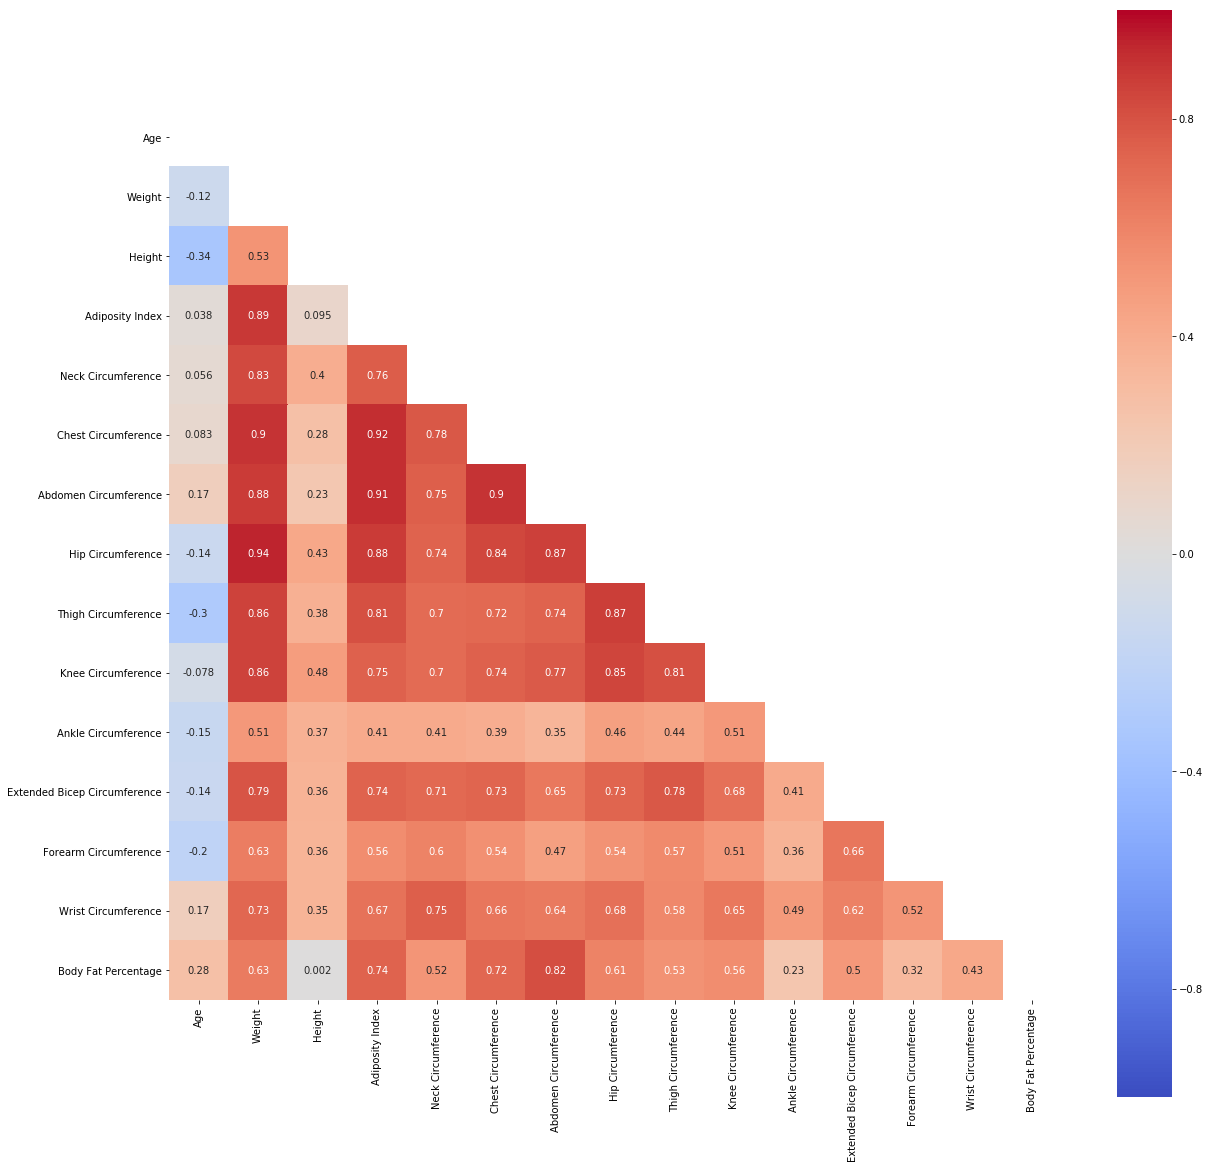

In [84]:
plt.figure(figsize=(20,20))
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap='coolwarm', annot=True, mask=mask)
plt.show()

## Attempt a 1-value regression for each column

In [53]:
test = data[data['sample'] == 'val']
test_performance = {'one_factor': {}}
for name in column_names[:-1]:
    test_performance['one_factor'][name] = performance(
        test[name].values.reshape(-1, 1),
        test['Body Fat Percentage'].values,
        regress(train[name].values.reshape(-1, 1), train['Body Fat Percentage'].values)
    )
print('Root mean squared error vs regressor')
print('------------------------------------')
for f, p in test_performance['one_factor'].items():
    print(f'{f}\t\t{p:0.2f}')

Root mean squared error vs regressor
------------------------------------
Age		6.56
Weight		5.80
Height		7.21
Adiposity Index		4.86
Neck Circumference		6.55
Chest Circumference		5.05
Abdomen Circumference		3.77
Hip Circumference		5.58
Thigh Circumference		6.19
Knee Circumference		6.68
Ankle Circumference		7.15
Extended Bicep Circumference		6.48
Forearm Circumference		6.61
Wrist Circumference		6.91


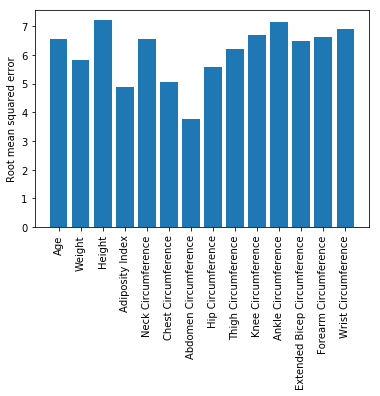

In [71]:
f = plt.figure()
plt.bar(x=column_names[:-1], height=[v for v in test_performance['one_factor'].values()])
plt.xticks(rotation=90)
plt.ylabel('Root mean squared error')
plt.show()

# Pairwise Regression

In [72]:
from itertools import combinations

In [76]:
combs = combinations(column_names[:-1], 2)

In [78]:
for _ in combs:
    c = [i for i in _]
    p = performance(test[c].values, test['Body Fat Percentage'].values,
                    regress(train[c].values, train['Body Fat Percentage'].values))
    print(f'{c} \t\t\t\t {p:0.2f}')

['Age', 'Height'] 				 6.61
['Age', 'Adiposity Index'] 				 4.70
['Age', 'Neck Circumference'] 				 6.09
['Age', 'Chest Circumference'] 				 4.94
['Age', 'Abdomen Circumference'] 				 3.76
['Age', 'Hip Circumference'] 				 4.75
['Age', 'Thigh Circumference'] 				 5.07
['Age', 'Knee Circumference'] 				 6.30
['Age', 'Ankle Circumference'] 				 6.43
['Age', 'Extended Bicep Circumference'] 				 5.85
['Age', 'Forearm Circumference'] 				 5.87
['Age', 'Wrist Circumference'] 				 6.51
['Weight', 'Height'] 				 5.14
['Weight', 'Adiposity Index'] 				 4.88
['Weight', 'Neck Circumference'] 				 5.80
['Weight', 'Chest Circumference'] 				 5.07
['Weight', 'Abdomen Circumference'] 				 3.54
['Weight', 'Hip Circumference'] 				 5.73
['Weight', 'Thigh Circumference'] 				 5.82
['Weight', 'Knee Circumference'] 				 5.84
['Weight', 'Ankle Circumference'] 				 5.68
['Weight', 'Extended Bicep Circumference'] 				 5.80
['Weight', 'Forearm Circumference'] 				 5.78
['Weight', 'Wrist Circumference'] 				 5

# All 14 Variables

In [94]:
p = performance(x_test=test[column_names[:-1]].values,
                y_test=test['Body Fat Percentage'].values,
                coefficients=regress(
                    train[column_names[:-1]].values,
                    train['Body Fat Percentage'].values,
                ))
test_performance['All inputs performance'] = p
print(f'All inputs performance\t\t{p:0.2f}')

All inputs performance		3.91


# My best guess

In [95]:
predictive_columns = ['Adiposity Index', 'Abdomen Circumference', 'Neck Circumference']
p = performance(x_test=test[predictive_columns].values,
                y_test=test['Body Fat Percentage'].values,
                coefficients=regress(
                    train[predictive_columns].values,
                    train['Body Fat Percentage'].values,
                ))
test_performance['Predictive columns performance'] = p
print(f'Predictive columns performance\t\t{p:0.2f}')

Predictive columns performance		3.45
